## Importing Required Libraries

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
from tensorflow.keras.optimizers import Adam
sns.set(style="darkgrid")

## Importing the Dataset

In [2]:
file_path = r"D:\\Paper Dataset\\apple_iphone_11_reviews.json"
df = pd.read_json(file_path)

# Display the first few rows of the DataFrame
print(df.shape)
df.head()

(5010, 11)


,product,helpful_count,total_comments,url,review_country,reviewed_at,review_text,review_rating,product_company,profile_name,review_title
0,Apple iPhone XR (64GB) - Black,"5,087 people found this helpful",24,https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...,India,2018-12-12,NOTE:,3.0 out of 5 stars,Apple,Sameer Patil,"Which iPhone you should Purchase ? iPhone 8, X..."
1,Apple iPhone XR (64GB) - Black,"2,822 people found this helpful",6,https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...,India,2018-11-17,Very bad experience with this iPhone xr phone....,1.0 out of 5 stars,Apple,Amazon Customer,Don't buy iPhone xr from Amazon.
2,Apple iPhone XR (64GB) - Black,"1,798 people found this helpful",0,https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...,India,2019-01-27,Amazing phone with amazing camera coming from ...,5.0 out of 5 stars,Apple,A,Happy with the purchase
3,Apple iPhone XR (64GB) - Black,"1,366 people found this helpful",14,https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...,India,2019-05-02,So I got the iPhone XR just today. The product...,1.0 out of 5 stars,Apple,Shubham Dutta,Amazon is not an apple authorised reseller. Pl...
4,Apple iPhone XR (64GB) - Black,536 people found this helpful,5,https://www.amazon.in/Apple-iPhone-XR-64GB-Bla...,India,2019-05-24,I've been an android user all my life until I ...,5.0 out of 5 stars,Apple,Nepuni Lokho,Excellent Battery life and buttery smooth UI


In [3]:
df["review_rating"].value_counts()

review_rating
5.0 out of 5 stars    3731
4.0 out of 5 stars     720
1.0 out of 5 stars     319
3.0 out of 5 stars     153
2.0 out of 5 stars      87
Name: count, dtype: int64

In [4]:
# Extract the numeric rating and convert to float
df['numeric_rating'] = df["review_rating"].str.extract(r'([0-9]+\.?[0-9]*)').astype(float)

df['numeric_rating'].value_counts()

numeric_rating
5.0    3731
4.0     720
1.0     319
3.0     153
2.0      87
Name: count, dtype: int64

In [5]:
# Function to convert ratings
def convert_rating(rating):
    if rating >= 4.0:
        return 'positive'
    elif rating == 3.0:
        return 'neutral'
    else:
        return 'negative'

# Apply the function to the rating column
df['categorical_rating'] = df['numeric_rating'].apply(convert_rating)

df['categorical_rating'].value_counts()

categorical_rating
positive    4451
negative     406
neutral      153
Name: count, dtype: int64

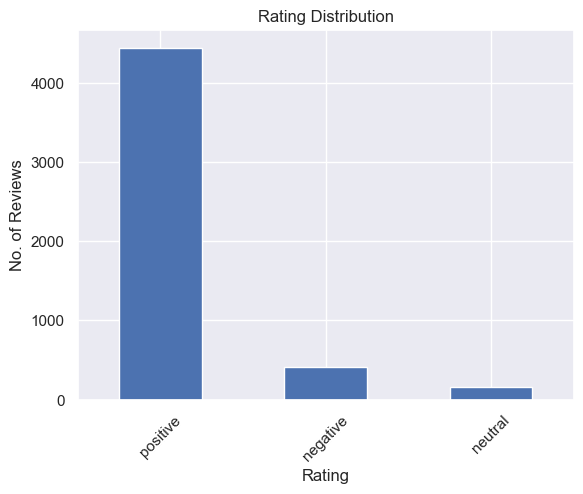

In [6]:
# Plot the value counts as a bar plot
df['categorical_rating'].value_counts().plot(kind='bar')

# Set the title and labels
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('No. of Reviews')

categories = df['categorical_rating'].value_counts().index  # Get the categories (which are the index of the value_counts Series)
custom_labels = [cat for cat in categories]  # Create custom labels
plt.xticks(ticks=range(len(categories)), labels=custom_labels, rotation=45)  # Set custom labels with rotation

# Show the plot
plt.show()

## Preparing Data for Model

In [7]:
# Step 1: Create X and y
X = df['review_text']
y = pd.get_dummies(df['categorical_rating'])  # Step 2: One-hot encode y

In [8]:
# Initial split: 80% for training, 20% for temporary dataset
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the temporary dataset equally into validation and test sets: 10% each of the original dataset
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize and prepare the data for BERT
def encode_reviews(tokenizer, reviews, max_length):
    return tokenizer.batch_encode_plus(
        reviews,
        add_special_tokens=True,
        return_attention_mask=True,
        pad_to_max_length=True,
        max_length=max_length,
        truncation = True,
        return_tensors='tf',
    )

# Choose a maximum sequence length for BERT
max_length = 256

# Encode the datasets
train_encodings = encode_reviews(tokenizer, X_train.tolist(), max_length)
val_encodings = encode_reviews(tokenizer, X_val.tolist(), max_length)
test_encodings = encode_reviews(tokenizer, X_test.tolist(), max_length)

C:\Users\Chetouani\anaconda3\envs\py310\lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [10]:
from transformers import TFBertModel
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model


# Load the pre-trained BERT model
bert = TFBertModel.from_pretrained('bert-base-uncased')

# Build the model
input_ids = Input(shape=(max_length,), dtype='int32', name='input_ids')
attention_masks = Input(shape=(max_length,), dtype='int32', name='attention_masks')

# Get the sequence output
sequence_output = bert(input_ids, attention_mask=attention_masks)[0]

# Select the first token's last hidden state
cls_token = sequence_output[:, 0, :]

# Add custom layers
x = Dense(512, activation='relu')(cls_token)
x = Dropout(0.1)(x)
x = Dense(256, activation='relu')(x)
output = Dense(y.shape[1], activation='softmax')(x)

# Compile the model
model = Model(inputs=[input_ids, attention_masks], outputs=output)

# Adjust the learning rate
optimizer = Adam(learning_rate=2e-5)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 256)]        0           []                               
                                                                                                  
 attention_masks (InputLayer)   [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_masks[0][0]']        
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                           

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_save_path = r"D:\Marketing Paper\best_model_apple.h5"

checkpoint = ModelCheckpoint(model_save_path, monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    [train_encodings['input_ids'], train_encodings['attention_mask']],
    y_train,
    validation_data=([
        val_encodings['input_ids'], val_encodings['attention_mask']
    ], y_val),
    epochs=10,
    batch_size=16,  # Specify your desired batch size here
    callbacks=[checkpoint]
)


Epoch 1/10
251/251 [==============================] - 126s 355ms/step - loss: 0.2646 - accuracy: 0.9089 - val_loss: 0.2234 - val_accuracy: 0.9281
Epoch 2/10
251/251 [==============================] - 87s 344ms/step - loss: 0.1750 - accuracy: 0.9449 - val_loss: 0.1983 - val_accuracy: 0.9301
Epoch 3/10
251/251 [==============================] - 82s 327ms/step - loss: 0.1266 - accuracy: 0.9553 - val_loss: 0.2145 - val_accuracy: 0.9301
Epoch 4/10
251/251 [==============================] - 82s 329ms/step - loss: 0.0898 - accuracy: 0.9731 - val_loss: 0.2907 - val_accuracy: 0.9242
Epoch 5/10
251/251 [==============================] - 83s 332ms/step - loss: 0.0754 - accuracy: 0.9763 - val_loss: 0.2802 - val_accuracy: 0.9222
Epoch 6/10
251/251 [==============================] - 83s 329ms/step - loss: 0.0509 - accuracy: 0.9838 - val_loss: 0.5408 - val_accuracy: 0.9062
Epoch 7/10
251/251 [==============================] - 83s 329ms/step - loss: 0.0322 - accuracy: 0.9913 - val_loss: 0.3736 - val_a

In [12]:
from tensorflow.keras.models import load_model

# Load the best model
best_model = load_model(model_save_path, custom_objects={'TFBertModel': TFBertModel})

# # Recompile the model with the optimizer, loss, and metrics
# model.compile(optimizer=Adam(learning_rate=2e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Evaluate the model on the test set
test_loss, test_acc = best_model.evaluate(
    [test_encodings['input_ids'], test_encodings['attention_mask']],
    y_test
)

print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

16/16 [==============================] - 10s 196ms/step - loss: 0.2490 - accuracy: 0.9301
Test Loss: 0.24903960525989532, Test Accuracy: 0.9301397204399109


In [14]:
from sklearn.metrics import classification_report, confusion_matrix

# Assuming `test_encodings` is already prepared similar to `train_encodings` and `val_encodings`
predictions = best_model.predict([test_encodings['input_ids'], test_encodings['attention_mask']])

# Assuming you have predictions from the model
predicted_class_indices = predictions.argmax(axis=1)

class_names = y_test.columns.tolist() 

# Convert y_test from one-hot encoding to class indices
true_class_indices = y_test.idxmax(axis=1).apply(class_names.index).values


# Generate the classification report using the true and predicted class indices
report = classification_report(true_class_indices, predicted_class_indices, target_names=class_names)
print(report)

# Generate the confusion matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)

# Calculate accuracy for each class
class_accuracies = cm.diagonal() / cm.sum(axis=1)
for class_name, accuracy in zip(class_names, class_accuracies):
    print(f'Accuracy for class {class_name}: {accuracy:.2f}')

16/16 [==============================] - 3s 184ms/step
              precision    recall  f1-score   support

    negative       0.73      0.72      0.73        46
     neutral       0.00      0.00      0.00        19
    positive       0.95      0.99      0.97       436

    accuracy                           0.93       501
   macro avg       0.56      0.57      0.57       501
weighted avg       0.89      0.93      0.91       501

Accuracy for class negative: 0.72
Accuracy for class neutral: 0.00
Accuracy for class positive: 0.99


C:\Users\Chetouani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chetouani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Chetouani\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu